In [8]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import importlib.util

current_working_directory = os.getcwd()
# Go one directory back
parent_directory = os.path.dirname(current_working_directory)
# Construct the path to the module, assuming the module is in the parent directory
calculations_module_path = os.path.join(parent_directory, "calculations_module.py")
# Load the module
spec = importlib.util.spec_from_file_location("calculations_module", calculations_module_path)
calculations_module = importlib.util.module_from_spec(spec)
sys.modules["calculations_module"] = calculations_module
spec.loader.exec_module(calculations_module)

import scipy.stats
import itertools
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib
from matplotlib.lines import Line2D

from scipy.interpolate import CubicSpline

### This code assumes that all the simulation l1 and the prediction l1 is already computed or that you have access to them!

#### A code to compute the l1 from the Takahshi's simulation for a given scale is given in another jupyter notebook. But this again assumes that the simulation data is already available.

In [2]:
tk_zs = np.array([0.0506, 0.5078, 1.0334, 1.2179, 1.4230, 1.6528, 1.9121, 2.0548, 2.3704, 3.9309, 5.3423])
zs_ = [tk_zs[3],tk_zs[4],tk_zs[7]]
theta1_input_ = [15., 18, 20]

In [3]:
class SimulationDataProcessor:
    def __init__(self, calculations_module, zs, theta1_input):
        self.parent_directory = "/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper/data/"
        self.calculations_module = calculations_module
        self.zs = zs
        self.theta1_input = theta1_input
        self.process_simulation_data()

    def format_zs(self):
        return str(self.zs).replace('.', '_')

    def construct_filenames(self, zs_formatted):
        filename_theory = f"theory_values_{zs_formatted}_{self.theta1_input}.npy"
        filename_simulation = f"simulation_values_{zs_formatted}_{self.theta1_input}.npy"
        return filename_theory, filename_simulation

    def load_data(self, file_path):
        return np.load(file_path).T

    def process_simulation_data(self):
        zs_formatted = self.format_zs()
        filename_theory, filename_simulation = self.construct_filenames(zs_formatted)

        file_path_theory = self.parent_directory + filename_theory
        file_path_sim = self.parent_directory + filename_simulation

        l1_theory_data = self.load_data(file_path_theory)
        self.l1_prediction, self.pdf_prediction, self.kappa_prediction = l1_theory_data[1], l1_theory_data[0], l1_theory_data[2]

        self.mean_pred, self.variance_pred, self.S_3_pred, self.K_pred, self.norm_pred = self.calculations_module.get_moments(self.kappa_prediction, self.pdf_prediction)

        l1_simulation_data = self.load_data(file_path_sim)
        self.mean_l1_simulation_data = np.mean(l1_simulation_data[0:9], axis=0)
        bw = l1_simulation_data[11][1]-l1_simulation_data[11][0]
        factor = 12*2048*2048
        self.mean_sim, self.variance_sim, self.S_3_sim, self.K_sim, self.norm_sim = self.calculations_module.get_moments(l1_simulation_data[11], self.mean_l1_simulation_data/np.abs(l1_simulation_data[11]))
        
        non_zero_indices = np.where(self.mean_l1_simulation_data != 0)[0]

        self.kappa_sim = l1_simulation_data[11][non_zero_indices]
        self.l1_sim = self.mean_l1_simulation_data[non_zero_indices]
        self.residual = (self.l1_sim - self.l1_prediction[non_zero_indices]) / self.l1_sim
        self.l1_err = np.std(l1_simulation_data[0:9], axis=0)[non_zero_indices]
        self.l1_residual_err = self.l1_err / self.l1_sim
        ind = 12
        self.kappa_sim_subset = self.kappa_sim[::ind]
        self.l1_sim_subset = self.l1_sim[::ind]
        self.residual_subset = self.residual[::ind]
        self.l1_err_subset = self.l1_err[::ind]
        self.l1_residual_err_subset = self.l1_residual_err[::ind]

        self.sigma = np.sqrt(self.variance_pred)
        self.gaussian = scipy.stats.norm.pdf(self.kappa_sim, loc=self.mean_sim, scale=self.sigma)
        self.gaussian_l1 = self.calculations_module.get_l1_from_pdf(self.gaussian, self.kappa_sim)
        self.gaussian_residual = (self.l1_sim - self.gaussian_l1) / self.l1_sim
        self.gaussian_residual_subset = self.gaussian_residual[::ind]
        self.lower_bound_l1 = self.residual_subset -3.*self.l1_residual_err_subset
        self.upper_bound_l1 = self.residual_subset + 3.*self.l1_residual_err_subset
        return 

zs = zs_[0]
theta1_input = theta1_input_[1]
results = SimulationDataProcessor(calculations_module, zs, theta1_input)



In [4]:
os.getcwd()

'/feynman/work/dap/lcs/vt272285/codes/LDT_2cell_l1_norm/paper'

     Type    zs  theta1          Mean  Variance  Skewness (S3)  Kurtosis (K)     Norm
Predicted 1.423    15.0 -4.179361e-10  0.000017     -44.122176      0.183658 1.000000
Simulated 1.423    15.0 -2.247731e-07  0.000017     -83.061572      0.622237 1.000571
Predicted 1.423    18.0 -3.555491e-09  0.000015     -43.910305      0.154840 1.000000
Simulated 1.423    18.0 -3.223853e-07  0.000015     -74.613046      0.438675 1.001698
Predicted 1.423    20.0 -2.890869e-09  0.000014     -43.715139      0.140105 1.000000
Simulated 1.423    20.0  1.739401e-07  0.000013     -76.663443      0.703153 1.108725


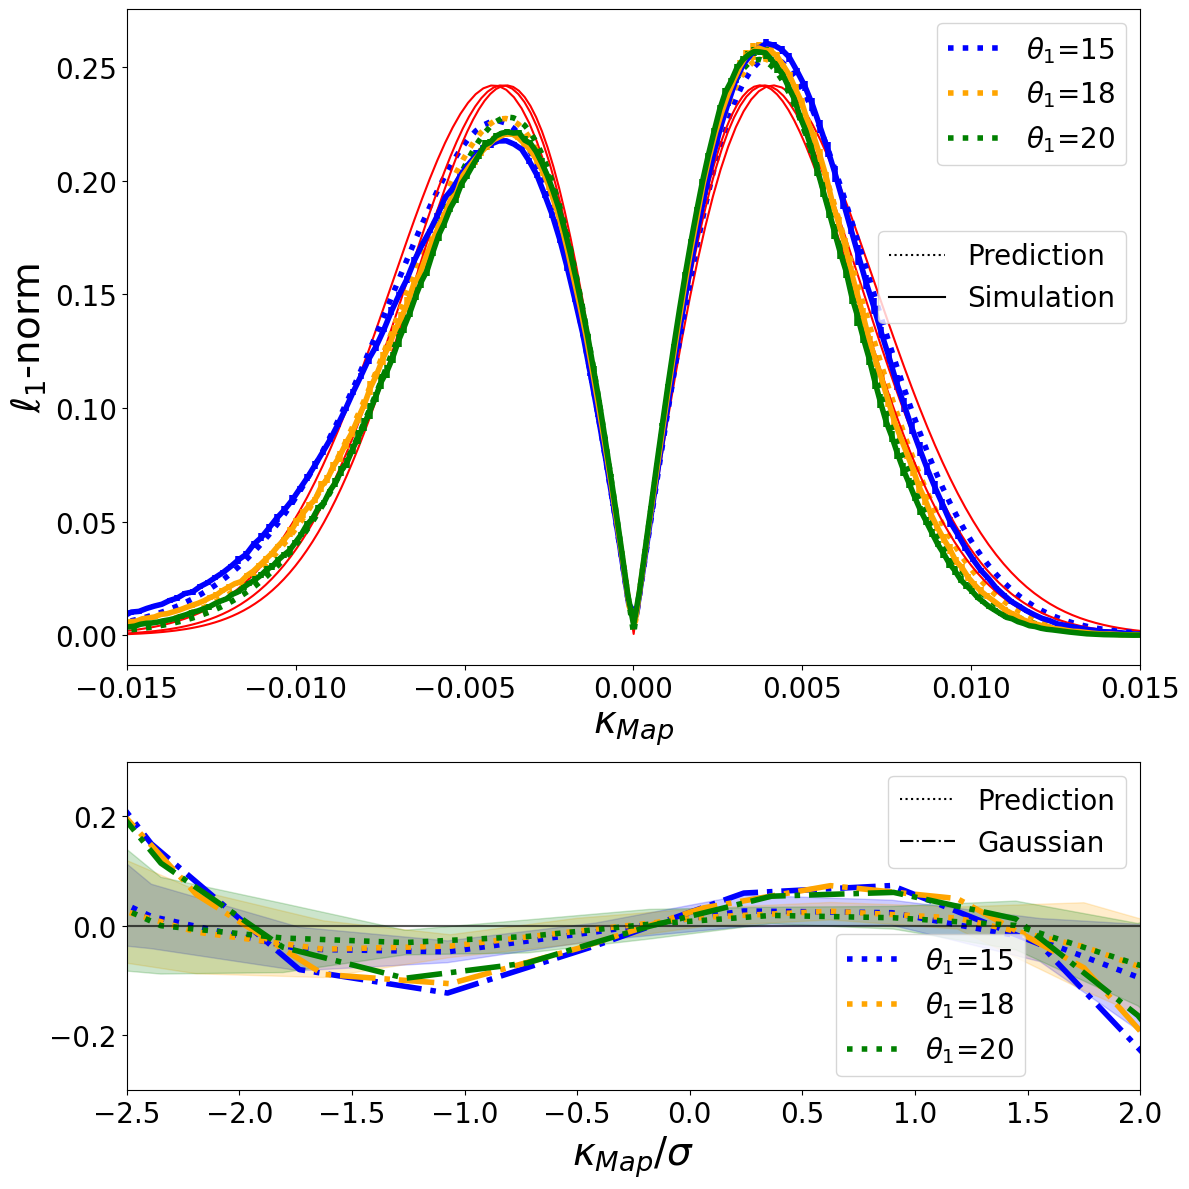

     Type     zs  theta1          Mean  Variance  Skewness (S3)  Kurtosis (K)     Norm
Predicted 1.2179      20 -3.048820e-09  0.000011     -55.583790      0.179514 1.000000
Simulated 1.2179      20 -3.764112e-07  0.000011     -94.528000      0.507194 1.002966
Predicted 1.4230      20 -2.890869e-09  0.000014     -43.715139      0.140105 1.000000
Simulated 1.4230      20  1.739401e-07  0.000013     -76.663443      0.703153 1.108725
Predicted 2.0548      20 -2.558617e-09  0.000024     -25.715793      0.080978 1.000000
Simulated 2.0548      20 -1.374156e-07  0.000024     -35.410846      0.151740 1.000632


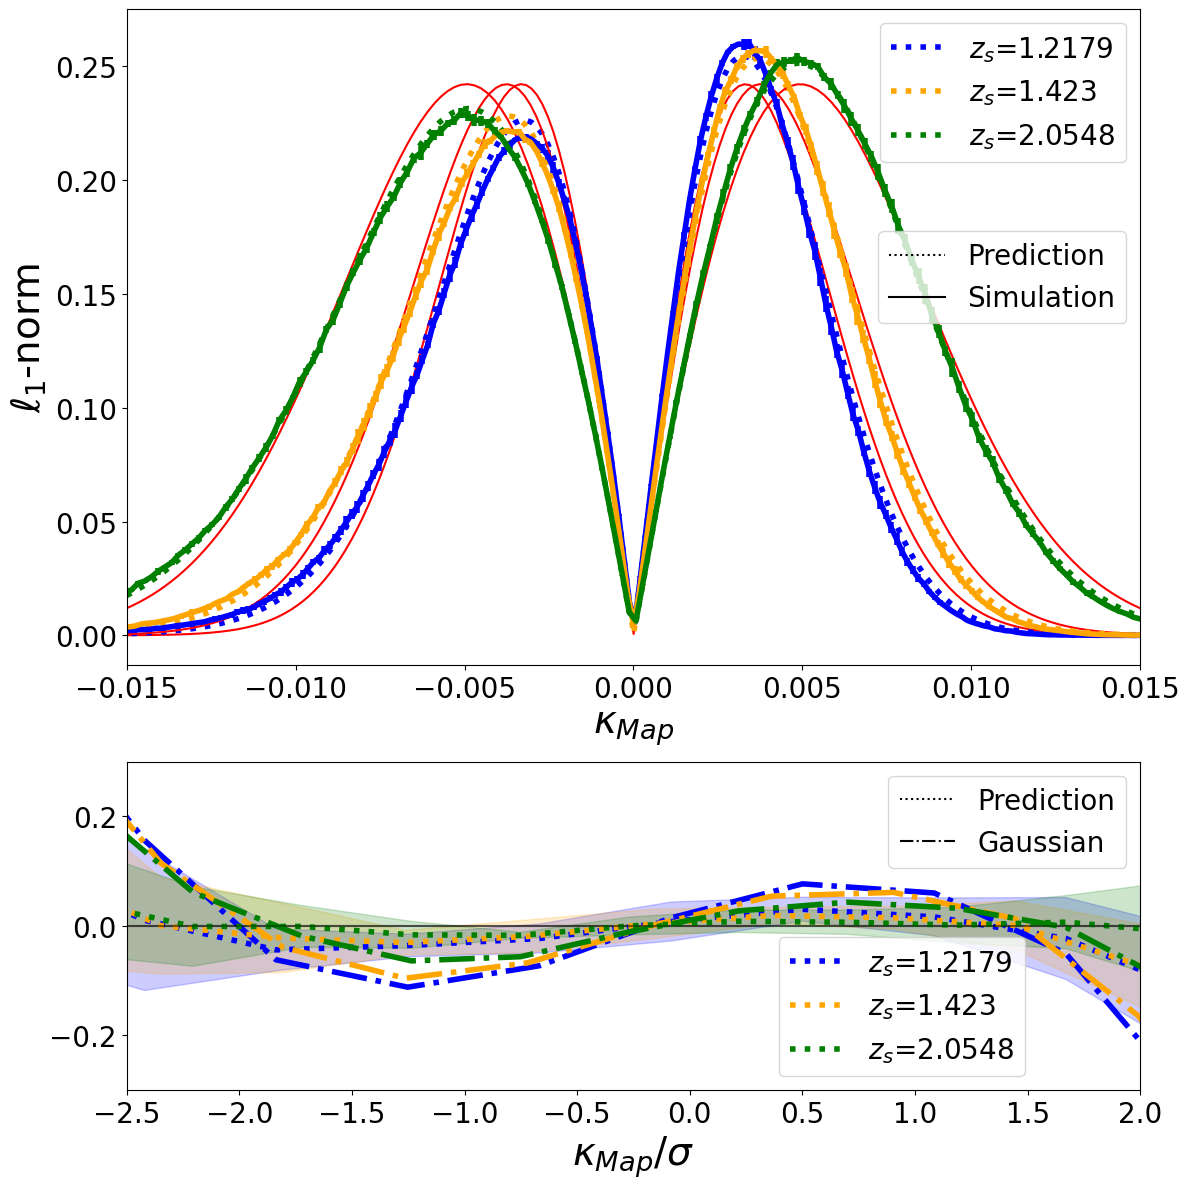

In [5]:
colours = ['blue', 'orange', 'green' ]
cc = itertools.cycle(colours)
plot_lines = []

fig = plt.figure(figsize=(12,12))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax0 = fig.add_subplot(gs[0, 0]) 
ax1 = fig.add_subplot(gs[1, 0])  

legend_zs_pdf = []  
legend_zs_pdf_residual = []
legend_zs_l1 = []  
legend_zs_l1_residual = []  

label_size = 28
legend_size = 20

data = []
for i in range(1,len(zs_)-1):
    for j in range(len(theta1_input_)):
        zs = zs_[i]
        theta1_input = theta1_input_[j]
        results = SimulationDataProcessor(calculations_module, zs, theta1_input)

        c = next(cc)
        
        ax0.plot(results.kappa_sim,results.gaussian_l1,c='r')
        l1_sim = ax0.errorbar(results.kappa_sim, results.l1_sim,yerr = results.l1_err,color=c, lw=4)       
        l1_pred, = ax0.plot(results.kappa_prediction, results.l1_prediction, color=c, ls=":", label=r'$\theta_1$=' + str(int(theta1_input)), lw=4)
         
        ax0.set_xlabel(r'$\kappa_{Map}$', size = label_size)
        ax0.set_ylabel(r'$\ell_1$-norm', size = label_size)
        ax0.set_xlim(-0.015,0.015)
        legend_zs_l1.append(l1_pred)
        
        l1_r2, = ax1.plot(results.kappa_sim_subset/results.sigma, results.gaussian_residual_subset, color=c, ls="-.", lw=4) 
        l1_r1 = ax1.plot(results.kappa_sim_subset/results.sigma, results.residual_subset ,c=c, label=r'$\theta_1$=' + str(int(theta1_input)), ls=":", lw=4) 

        ax1.set_xlim(-2.5,2.) 
        ax1.set_ylim(-0.3,0.3) 
        ax1.hlines(0,-2.5,2, color='black',alpha=0.3)
        ax1.set_xlabel(r'$\kappa_{Map}/\sigma$', size = label_size)
        ax1.fill_between(results.kappa_sim_subset/results.sigma, results.lower_bound_l1, results.upper_bound_l1, color=c, alpha=0.2)
        legend_zs_l1_residual.append(l1_r1)
        
        mu_pred, var_pred, s3_pred, kurt_pred, norm_pred = results.mean_pred, results.variance_pred, results.S_3_pred, results.K_pred, results.norm_pred
        mu_sim, var_sim, s3_sim, kurt_sim, norm_sim = results.mean_sim, results.variance_sim, results.S_3_sim, results.K_sim, results.norm_sim
        data.append(["Predicted", zs, theta1_input, mu_pred, var_pred, s3_pred, kurt_pred, norm_pred])
        data.append(["Simulated", zs, theta1_input, mu_sim, var_sim, s3_sim, kurt_sim, norm_sim])

# Create DataFrame
df = pd.DataFrame(data, columns=["Type","zs","theta1", "Mean", "Variance", "Skewness (S3)", "Kurtosis (K)", "Norm"])
print(df.to_string(index=False, max_colwidth=None, line_width=1000))

       
legend_zs_box = ax0.legend(handles=legend_zs_l1, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle=":", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle="-", color='black', label='Simulation')]
ax0.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1.0, 0.5), fontsize=legend_size)
plt.tight_layout()
ax0.add_artist(legend_zs_box)

legend_zs_box = ax1.legend(handles=legend_zs_l1, loc='lower right', bbox_to_anchor=(0.9, .0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle=":", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle="-.", color='black', label='Gaussian')]
ax1.legend(handles=custom_legend, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
plt.tight_layout()
ax1.add_artist(legend_zs_box)
plt.savefig(os.getcwd()+"/alltheta_z1_4.jpeg", dpi=600)
plt.show()

colours = ['blue', 'orange', 'green' ]
cc = itertools.cycle(colours)
plot_lines = []

fig = plt.figure(figsize=(12,12))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])

ax0 = fig.add_subplot(gs[0, 0]) 
ax1 = fig.add_subplot(gs[1, 0])  

legend_zs_pdf = []  
legend_zs_pdf_residual = []
legend_zs_l1 = []  
legend_zs_l1_residual = []  

label_size = 28
legend_size = 20

data = []
for i in range(len(zs_)):
    for j in range(2,len(theta1_input_)):
        zs = zs_[i]
        theta1_input = theta1_input_[j]
        results = SimulationDataProcessor(calculations_module, zs, theta1_input)

        c = next(cc)
        
        ax0.plot(results.kappa_sim,results.gaussian_l1,c='r')
        l1_sim = ax0.errorbar(results.kappa_sim, results.l1_sim,yerr = results.l1_err,color=c, lw=4)       
        # l1_pred, = ax0.plot(results.kappa_prediction, results.l1_prediction, color=c, ls=":", label=r'$\theta_1$=' + str(int(theta1_input)), lw=4)
        l1_pred, = ax0.plot(results.kappa_prediction, results.l1_prediction, color=c, ls=":", label=f'$z_s$={zs}', lw=4)
         
        ax0.set_xlabel(r'$\kappa_{Map}$', size = label_size)
        ax0.set_ylabel(r'$\ell_1$-norm', size = label_size)
        ax0.set_xlim(-0.015,0.015)
        legend_zs_l1.append(l1_pred)
        
        l1_r2, = ax1.plot(results.kappa_sim_subset/results.sigma, results.gaussian_residual_subset, color=c, ls="-.", lw=4) 
        # l1_r1 = ax1.plot(results.kappa_sim_subset/results.sigma, results.residual_subset ,c=c, label=r'$\theta_1$=' + str(int(theta1_input)), ls=":", lw=3) 
        l1_r1 = ax1.plot(results.kappa_sim_subset/results.sigma, results.residual_subset ,c=c, label=f'$z_s$={zs}', ls=":", lw=4)

        ax1.set_xlim(-2.5,2.) 
        ax1.set_ylim(-0.3,0.3) 
        ax1.hlines(0,-2.5,2, color='black',alpha=0.3)
        ax1.set_xlabel(r'$\kappa_{Map}/\sigma$', size = label_size)
        ax1.fill_between(results.kappa_sim_subset/results.sigma, results.lower_bound_l1, results.upper_bound_l1, color=c, alpha=0.2)
        legend_zs_l1_residual.append(l1_r1)
        mu_pred, var_pred, s3_pred, kurt_pred, norm_pred = results.mean_pred, results.variance_pred, results.S_3_pred, results.K_pred, results.norm_pred
        mu_sim, var_sim, s3_sim, kurt_sim, norm_sim = results.mean_sim, results.variance_sim, results.S_3_sim, results.K_sim, results.norm_sim
        data.append(["Predicted", zs, theta1_input, mu_pred, var_pred, s3_pred, kurt_pred, norm_pred])
        data.append(["Simulated", zs, theta1_input, mu_sim, var_sim, s3_sim, kurt_sim, norm_sim])

# Create DataFrame
df = pd.DataFrame(data, columns=["Type","zs","theta1", "Mean", "Variance", "Skewness (S3)", "Kurtosis (K)", "Norm"])
print(df.to_string(index=False, max_colwidth=None, line_width=1000)) 

legend_zs_box = ax0.legend(handles=legend_zs_l1, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle=":", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle="-", color='black', label='Simulation')]
ax0.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1.0, 0.5), fontsize=legend_size)
plt.tight_layout()
ax0.add_artist(legend_zs_box)

legend_zs_box = ax1.legend(handles=legend_zs_l1, loc='lower right', bbox_to_anchor=(0.9, .0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle=":", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle="-.", color='black', label='Gaussian')]
ax1.legend(handles=custom_legend, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
plt.tight_layout()
ax1.add_artist(legend_zs_box)
plt.savefig(os.getcwd()+"/allz_theta20.jpeg", dpi=600)
plt.show()
        

In [6]:
model_dict = {
    "model_one": {
        "mnv": 0.00000,
        "om": 0.30000,
        "As": 2.1000,
    },
    "model_two": {
        "mnv": 0.09041,
        "om": 0.28447,
        "As": 2.1757,
    },
    "model_three": {
        "mnv": 0.10000,
        "om": 0.30000,
        "As": 2.1000,
    },
    "model_four": {
        "mnv": 0.11874,
        "om": 0.31434,
        "As": 2.0079,
    }
}

def get_params(model_name):
    if model_name in model_dict:
        model_parameters = model_dict[model_name]
        mnv = model_parameters["mnv"]
        om = model_parameters["om"]
        As = model_parameters["As"]
    else:
        print(f"Model {model_name} not found in the dictionary. Please check your inputs.")
    return mnv, om, As

def get_loaded_pdf(mnv, om, As,window_radius, redshift):
    main_folder = "/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/"
    filename = main_folder +  f"prediction_pdf_redshift{redshift}_mnv{mnv:.5f}_As{As:.4f}_Om{om:.5f}_radius{window_radius}.npy"
    print(filename)
    # Load the data from the .npy file
    data = np.load(filename, allow_pickle=True).item()

    # Access the loaded data
    kappa = data["kappa"]
    pdf_prediction = data["prediction"]
    pdf_simulation = data["simulation"]
    std_simulation = data['std_sim']
    return kappa, pdf_prediction, pdf_simulation, std_simulation

def get_loaded_l1(mnv, om, As,window_radius, redshift):
    main_folder = "/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/"
    filename_pred = main_folder +  f"prediction_l1_redshift{redshift}_mnv{mnv:.5f}_As{As:.4f}_Om{om:.5f}_radius{window_radius}.npy"
    print(filename_pred)
    # Load the data from the .npy file
    data = np.load(filename_pred, allow_pickle=True).item()
    # Access the loaded data
    kappa = data["kappa"]
    l1_prediction = data["prediction"]
    l1_simulation = data["simulation"]
    std_sim = data["std_sim"]
    
    # window_radius = 25
    # filename_sim = main_folder + f"aperture_convergence_l1_redshift{redshift}_mnv{mnv:.5f}_As{As:.4f}_Om{om:.5f}_radius{window_radius}.npy"
    # data_sim = np.load(filename_sim, allow_pickle=True).item()
    # l1_simulation = data_sim["l1"]
    # std_sim = data_sim["std"]
    # bin_simulation = data_sim["bin_edges"]
    return kappa, l1_prediction, l1_simulation, std_sim

In [9]:
window_radius = 22.55859375 #10.25
redshift = 2


def get_splines_pdf(model):
    mnv, om, As = get_params(model)
    kappa, pred, sim, err = get_loaded_pdf(mnv, om, As, window_radius, redshift)
    # plt.plot(kappa,pred)
    pred_spline = CubicSpline(kappa,pred)
    sim_spline = CubicSpline(kappa,sim)
    # err_spline = CubicSpline(kappa,err)
    
    return mnv, om, As, pred_spline, sim_spline #, err_spline

def get_splines_l1(model):
    mnv, om, As = get_params(model)
    kappa, pred, sim, err = get_loaded_l1(mnv, om, As, window_radius, redshift)
    pred_spline = CubicSpline(kappa,pred)
    # err_spline = CubicSpline(kappa,err)
    sim_spline = CubicSpline(kappa,sim)
    return pred_spline, sim_spline #, err_spline

mnv_1, om_1, As_1, pdf_pred_1, pdf_sim_1 = get_splines_pdf("model_one")
mnv_2, om_2, As_2, pdf_pred_2, pdf_sim_2 = get_splines_pdf("model_two") 
mnv_3, om_3, As_3, pdf_pred_3, pdf_sim_3 = get_splines_pdf("model_three") 
mnv_4, om_4, As_4, pdf_pred_4, pdf_sim_4 = get_splines_pdf("model_four") 
l1_pred_1, l1_sim_1 = get_splines_l1("model_one")
l1_pred_2, l1_sim_2 = get_splines_l1("model_two") 
l1_pred_3, l1_sim_3 = get_splines_l1("model_three") 
l1_pred_4, l1_sim_4 = get_splines_l1("model_four")  



/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_pdf_redshift2_mnv0.00000_As2.1000_Om0.30000_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_pdf_redshift2_mnv0.09041_As2.1757_Om0.28447_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_pdf_redshift2_mnv0.10000_As2.1000_Om0.30000_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_pdf_redshift2_mnv0.11874_As2.0079_Om0.31434_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_l1_redshift2_mnv0.00000_As2.1000_Om0.30000_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_l1_redshift2_mnv0.09041_As2.1757_Om0.28447_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_l1_redshift2_mnv0.10000_As2.1000_Om0.30000_radius22.55859375.npy
/feynman/work/dap/lcs/vt272285/codes/massivenus_pdf/prediction_l1_redshift2_mnv0.11874_As2.0079_Om0.

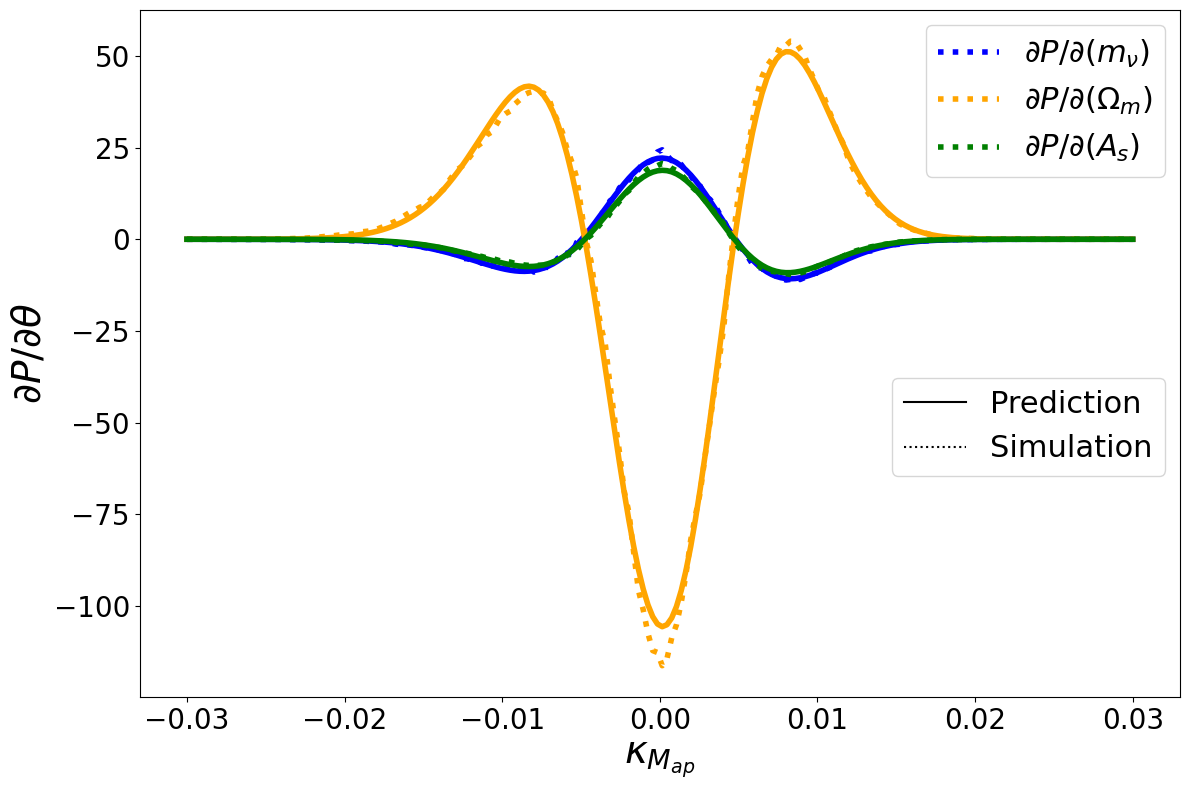

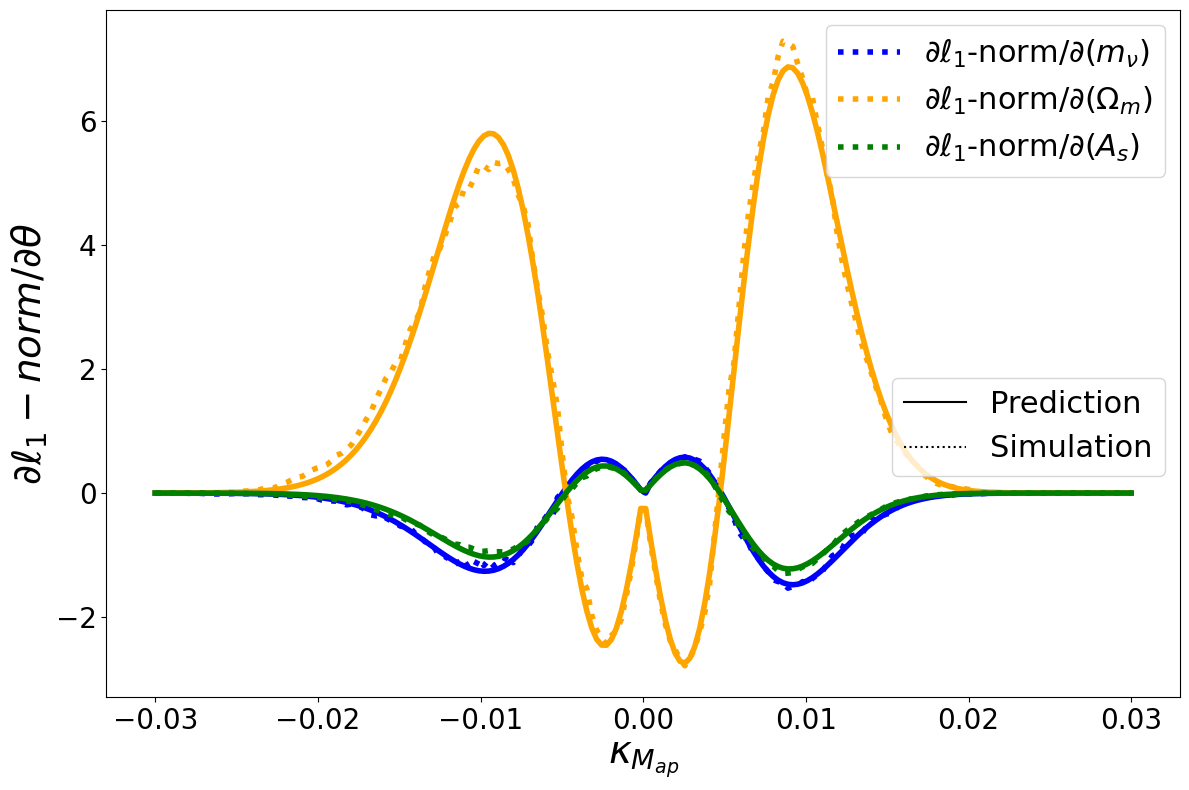

In [11]:
legend_elements_1 = [
    Line2D([0], [0], color='blue', linestyle='-', label=r'Prediction at $\theta=22.55$'),
    Line2D([0], [0], color='blue', linestyle='--', label='Simulation'),
]


kappa = np.linspace(-0.03,0.03,200)

fig = plt.figure(figsize=(12,8))
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

ax0 = fig.add_subplot(1,1,1) 


legend_size = 22
label_size = 28
line_width = 4 
ax0.plot(kappa,(pdf_pred_3(kappa)-pdf_pred_1(kappa))/(mnv_3-mnv_1),c='blue', lw = line_width)
dp1, = ax0.plot(kappa,(pdf_sim_3(kappa)-pdf_sim_1(kappa))/(mnv_3-mnv_1),ls=":", c='blue', label=r'$\partial P / \partial(m_\nu)$',lw = line_width)

ax0.plot(kappa,(pdf_pred_4(kappa)-pdf_pred_2(kappa))*0.5/(om_4-om_2),c='orange', lw = line_width)
dp2, = ax0.plot(kappa,(pdf_sim_4(kappa)-pdf_sim_2(kappa))*0.5/(om_4-om_2),ls=":",c='orange', label=r'$\partial P / \partial(\Omega_m)$', lw = line_width)

ax0.plot(kappa,(pdf_pred_2(kappa)-pdf_pred_4(kappa))*0.5/(As_2-As_4),c='green', lw = line_width)
dp3, = ax0.plot(kappa,(pdf_sim_2(kappa)-pdf_sim_4(kappa))*0.5/(As_2-As_4),ls=":",c='green', label=r'$\partial P / \partial(A_s)$', lw = line_width)

legend_pdf = [dp1,dp2,dp3]
ax0.set_ylabel(r"$\partial P/\partial \theta$",fontsize=label_size)
ax0.set_xlabel(r'$\kappa_{M_{ap}}$',fontsize=label_size)

legend_zs_box = ax0.legend(handles=legend_pdf, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle="-", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle=":", color='black', label='Simulation')]
ax0.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1, 0.3), fontsize=legend_size)
plt.tight_layout()
ax0.add_artist(legend_zs_box)
plt.savefig(os.getcwd()+"/derivative_pdf.jpeg", dpi=600)
# plt.legend(handles=legend_elements_1, loc='upper right')
# ax0.grid(True)

fig = plt.figure(figsize=(12,8))
matplotlib.rc('xtick', labelsize=20) 
ax1 = fig.add_subplot(1,1,1)  

index = np.where(np.abs(kappa) - 0. == np.min(np.abs(kappa)-0.))
l1_pred3 = l1_pred_3(kappa)
l1_pred1 = l1_pred_1(kappa)
l1_sim3 = l1_sim_3(kappa)
l1_sim1 = l1_sim_1(kappa)


l1_dpred = l1_pred3-l1_pred1
l1_dpred[index[0]] = 0.0
l1_dsim = l1_sim3-l1_sim1
l1_dsim[index[0]] = 0.0

ax1.plot(kappa,(l1_dpred)/(mnv_3-mnv_1),c='blue', lw = line_width)
dl1, = ax1.plot(kappa,(l1_dsim)/(mnv_3-mnv_1),ls=":",c='blue',  label=r'$\partial \ell_1$-norm$/ \partial(m_\nu)$', lw = line_width)

ax1.plot(kappa,(l1_pred_4(kappa)-l1_pred_2(kappa))*0.5/(om_4-om_2),c='orange', lw = line_width)
dl2, = ax1.plot(kappa,(l1_sim_4(kappa)-l1_sim_2(kappa))*0.5/(om_4-om_2),ls=":",c='orange',  label=r'$\partial \ell_1$-norm$/ \partial(\Omega_m)$', lw = line_width)
# ax1.ylabel(r'$\partial \ell_1(\kappa_{Map}) / \partial \Omega_m$',fontsize=15)

ax1.plot(kappa,(l1_pred_2(kappa)-l1_pred_4(kappa))*0.5/(As_2-As_4),c='green', lw = line_width)
dl3, = ax1.plot(kappa,(l1_sim_2(kappa)-l1_sim_4(kappa))*0.5/(As_2-As_4),ls=":",c='green',  label=r'$\partial \ell_1$-norm$/ \partial(A_s)$', lw = line_width)


legend_l1 = [dl1,dl2,dl3]
ax1.set_ylabel(r"$\partial \ell_1-norm/\partial \theta$",fontsize=label_size)
ax1.set_xlabel(r'$\kappa_{M_{ap}}$',fontsize=label_size)

legend_zs_box = ax1.legend(handles=legend_l1, loc='upper right', bbox_to_anchor=(1.0, 1.0), fontsize=legend_size)
custom_legend = [Line2D([0], [0], linestyle="-", color='black', label='Prediction'),
                 Line2D([0], [0], linestyle=":", color='black', label='Simulation')]
ax1.legend(handles=custom_legend, loc='lower right', bbox_to_anchor=(1, 0.3), fontsize=legend_size)
plt.tight_layout()
ax1.add_artist(legend_zs_box)
plt.savefig(os.getcwd()+"/derivative_l1_norm.jpeg", dpi=600)
# ax1.grid(True)